#Data Loading#

In [ ]:
!unzip -q "/content/CUAD_v1.json.zip" -d "/content/cuad_data"
import os
os.listdir("/content/cuad_data")


replace /content/cuad_data/CUAD_v1.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


['CUAD_v1.json']

In [ ]:
import json

# Replace with the correct path if different
with open("/content/cuad_data/CUAD_v1.json", "r") as f:
    cuad_data = json.load(f)

# Now try this again
contracts = cuad_data["data"]

import json
print(json.dumps(contracts[0], indent=2)[:1000])


{
  "title": "LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGREEMENT",
  "paragraphs": [
    {
      "qas": [
        {
          "answers": [
            {
              "text": "DISTRIBUTOR AGREEMENT",
              "answer_start": 44
            }
          ],
          "id": "LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGREEMENT__Document Name",
          "question": "Highlight the parts (if any) of this contract related to \"Document Name\" that should be reviewed by a lawyer. Details: The name of the contract",
          "is_impossible": false
        },
        {
          "answers": [
            {
              "text": "Distributor",
              "answer_start": 244
            },
            {
              "text": "Electric City Corp.",
              "answer_start": 148
            },
            {
              "text": "Electric City of Illinois L.L.C.",
              "answer_start": 49574
            },
            {
              "text": "Company",
              "answer_start

In [ ]:
import json
import pandas as pd
import re

# Load CUAD JSON file
with open("/content/cuad_data/CUAD_v1.json", "r") as f:
    cuad_data = json.load(f)

# Extract records
contracts = cuad_data["data"]
records = []

for contract in contracts:
    title = contract.get("title", "Unknown Title")
    for paragraph in contract.get("paragraphs", []):
        for qa in paragraph.get("qas", []):
            question = qa.get("question", "")
            match = re.search(r'"(.*?)"', question)
            clause_type = match.group(1) if match else question
            for ans in qa.get("answers", []):
                clause_text = ans.get("text", "").strip()
                if clause_text:
                    records.append({
                        "contract_title": title,
                        "clause_type": clause_type,
                        "clause_text": clause_text
                    })

# Create DataFrame
df = pd.DataFrame(records)

# Clean clause text
df["clause_text_clean"] = df["clause_text"].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

# Now apply the clause type extractor again (optional here since already done above)
def extract_clause_type(question):
    match = re.search(r'"(.*?)"', question)
    return match.group(1) if match else question

df["clause_type"] = df["clause_type"].apply(extract_clause_type)

# Preview
df.head(10)


,contract_title,clause_type,clause_text,clause_text_clean
0,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,Document Name,DISTRIBUTOR AGREEMENT,DISTRIBUTOR AGREEMENT
1,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,Parties,Distributor,Distributor
2,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,Parties,Electric City Corp.,Electric City Corp.
3,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,Parties,Electric City of Illinois L.L.C.,Electric City of Illinois L.L.C.
4,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,Parties,Company,Company
5,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,Parties,Electric City of Illinois LLC,Electric City of Illinois LLC
6,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,Agreement Date,"7th day of September, 1999.","7th day of September, 1999."
7,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,Effective Date,The term of this Agreement shall be ten (10)...,The term of this Agreement shall be ten (10) y...
8,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,Effective Date,Unless earlier terminated otherwise prov...,Unless earlier terminated otherwise provided t...
9,LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGRE...,Expiration Date,The term of this Agreement shall be ten (10)...,The term of this Agreement shall be ten (10) y...


#Data Preprocessing#

In [ ]:
import re

def clean_text(text):
    # Remove multiple spaces, newlines, tabs
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Apply cleaning
df["clause_text_clean"] = df["clause_text"].apply(clean_text)

# Preview cleaned clauses
df[["clause_type", "clause_text_clean"]].head(10)


,clause_type,clause_text_clean
0,Document Name,DISTRIBUTOR AGREEMENT
1,Parties,Distributor
2,Parties,Electric City Corp.
3,Parties,Electric City of Illinois L.L.C.
4,Parties,Company
5,Parties,Electric City of Illinois LLC
6,Agreement Date,"7th day of September, 1999."
7,Effective Date,The term of this Agreement shall be ten (10) y...
8,Effective Date,Unless earlier terminated otherwise provided t...
9,Expiration Date,The term of this Agreement shall be ten (10) y...


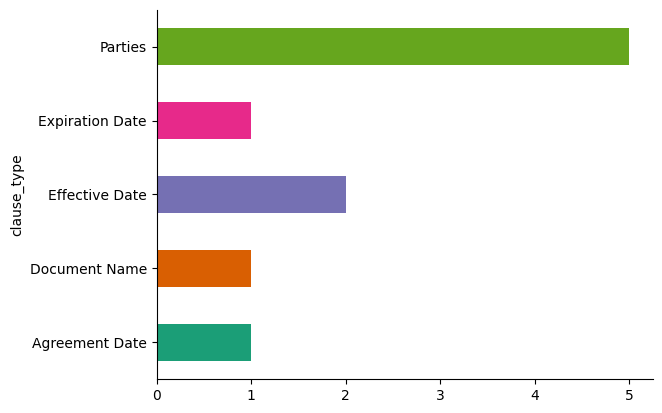

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('clause_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

#Vector Embedding#

In [ ]:
from sentence_transformers import SentenceTransformer

# Load free model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings from cleaned clause text
embeddings = model.encode(df["clause_text_clean"].tolist(), show_progress_bar=True)

# Store each embedding as a list in the dataframe
df["embedding"] = embeddings.tolist()


Batches:   0%|          | 0/432 [00:00<?, ?it/s]

In [ ]:
# Check shape of the first embedding
print("✅ Embedding length (first row):", len(df["embedding"][0]))

# Show first 2 rows with clause type and vector
df[["clause_type", "clause_text_clean", "embedding"]].head(10)


✅ Embedding length (first row): 384


,clause_type,clause_text_clean,embedding
0,Document Name,DISTRIBUTOR AGREEMENT,"[-0.02880561724305153, -0.00735632237046957, -..."
1,Parties,Distributor,"[-0.026355423033237457, -0.03511001914739609, ..."
2,Parties,Electric City Corp.,"[-0.05583993345499039, 0.0603022426366806, -0...."
3,Parties,Electric City of Illinois L.L.C.,"[-0.024052124470472336, 0.061359964311122894, ..."
4,Parties,Company,"[-0.06740855425596237, 0.003505291184410453, -..."
5,Parties,Electric City of Illinois LLC,"[-0.044040147215127945, 0.08986777812242508, 0..."
6,Agreement Date,"7th day of September, 1999.","[-0.07278163731098175, 0.016368281096220016, -..."
7,Effective Date,The term of this Agreement shall be ten (10) y...,"[-0.025703702121973038, 0.01040123961865902, -..."
8,Effective Date,Unless earlier terminated otherwise provided t...,"[-0.04152815416455269, 0.016955461353063583, 0..."
9,Expiration Date,The term of this Agreement shall be ten (10) y...,"[-0.025703713297843933, 0.010401252657175064, ..."


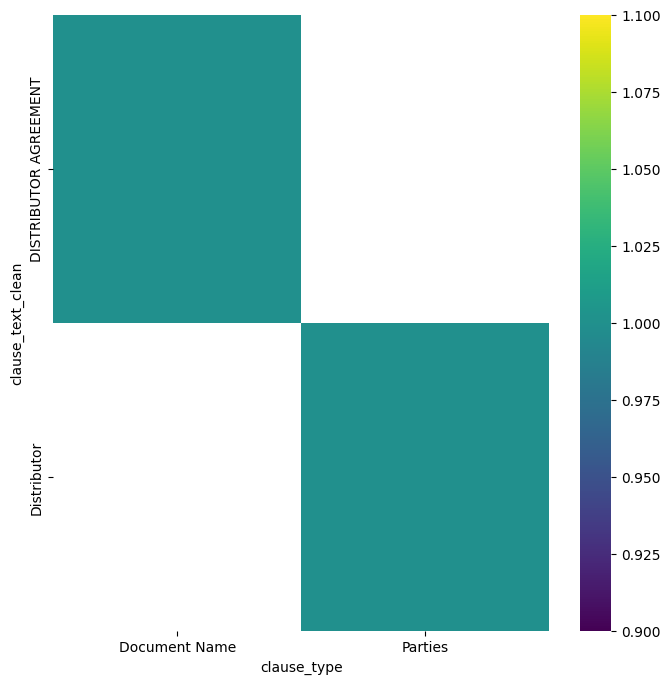

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['clause_text_clean'].value_counts()
    for x_label, grp in _df_3.groupby('clause_type')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('clause_type')
_ = plt.ylabel('clause_text_clean')

#Semantic Search (Using FAISS)#

In [ ]:
!pip install faiss-cpu --quiet
import faiss
import numpy as np

# Convert list of embeddings to numpy array
embedding_matrix = np.array(df["embedding"].to_list()).astype("float32")


In [ ]:
# Initialize FAISS index (for 384-dim vectors)
index = faiss.IndexFlatL2(384)
index.add(embedding_matrix)

print("✅ FAISS index created with", index.ntotal, "clauses.")


✅ FAISS index created with 13823 clauses.


In [ ]:
from sentence_transformers import SentenceTransformer

query = "termination notice period"
query_vector = model.encode([query]).astype("float32")

# Search top 5 closest clauses
k = 5
distances, indices = index.search(query_vector, k)

# Show results
print("\n🔍 Top 5 clauses similar to:", query)
for idx in indices[0]:
    print(f"\n🔸 Clause Type: {df.iloc[idx]['clause_type']}")
    print(f"📄 Clause: {df.iloc[idx]['clause_text_clean']}")



🔍 Top 5 clauses similar to: termination notice period

🔸 Clause Type: Renewal Term
📄 Clause: If no termination notice is provided, the Agreement will be automatically extended for consecutive *** periods until such time as *** termination notice is provided.

🔸 Clause Type: Post-Termination Services
📄 Clause: Upon and after the termination of this Agreement (the "Termination Date"):

🔸 Clause Type: Post-Termination Services
📄 Clause: After notice of termination has been given by you or the Company, the Company may at its discretion require you, for all or part of your notice period, to comply with any or all of the following instructions: (a) not to carry out any further work for the Company or for any Group Company; (b) to remain away from the Company's business premises and those of any Group

🔸 Clause Type: Non-Compete
📄 Clause: Agreement may be terminated prior to the conclusion of the Term by giving written notice of termination:

🔸 Clause Type: Termination For Convenience
📄 Clau

In [ ]:
from sentence_transformers import SentenceTransformer
query = "who signed the agreement"

query_vector = model.encode([query]).astype("float32")

# Search top 5 closest clauses
k = 5
distances, indices = index.search(query_vector, k)

# Show results
print("\n🔍 Top 5 clauses similar to:", query)
for idx in indices[0]:
    print(f"\n🔸 Clause Type: {df.iloc[idx]['clause_type']}")
    print(f"📄 Clause: {df.iloc[idx]['clause_text_clean']}")



🔍 Top 5 clauses similar to: who signed the agreement

🔸 Clause Type: Governing Law
📄 Clause: This Agreement was negotiated and is being contracted

🔸 Clause Type: Governing Law
📄 Clause: This Agreement and any action

🔸 Clause Type: Document Name
📄 Clause: Collaboration Agreement

🔸 Clause Type: Document Name
📄 Clause: COLLABORATION AGREEMENT

🔸 Clause Type: Document Name
📄 Clause: Collaboration Agreement


#Clause Risk Explanation#

In [ ]:
!pip install -q faiss-cpu sentence-transformers
import re
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')


In [ ]:
risk_patterns = [
    # 🔴 Termination
    {"pattern": r"terminate.*without.*notice", "reason": "Allows termination without notice"},
    {"pattern": r"terminate.*for.*any.*reason", "reason": "Termination clause is too broad"},
    {"pattern": r"unilateral.*termination", "reason": "One party can terminate without cause"},

    # 🔁 Auto-Renewal
    {"pattern": r"(auto|automatic(ally)?)\s*[-]?\s*renew.*indefinitely", "reason": "Automatically renews indefinitely"},
    {"pattern": r"renew.*whenever.*(party|shareholder|they|wants?)", "reason": "Unclear or party-controlled renewal terms"},

    # 📅 Term Length / Dates
    {"pattern": r"no.*expiration.*date", "reason": "Contract has no expiration"},
    {"pattern": r"term.*longer.*than.*10.*years", "reason": "Contract duration exceeds 10 years"},

    # ⚖️ Jurisdiction / Governing Law
    {"pattern": r"exclusive.*jurisdiction.*(New York|outside|foreign)", "reason": "Unfavorable or inconvenient jurisdiction"},
    {"pattern": r"waive.*jury.*trial", "reason": "Jury trial is waived"},

    # 🔐 Confidentiality & Data
    {"pattern": r"confidential.*disclos.*to.*third[-\s]?part(y|ies)", "reason": "Allows third-party disclosure of confidential info"},
    {"pattern": r"data.*retention.*after.*termination", "reason": "Data may be stored post termination"},
    {"pattern": r"no.*data.*deletion.*right", "reason": "No right to delete data"},

    # 💰 Payment & Penalty
    {"pattern": r"late.*payment.*penalt(y|ies).*more.*than.*10%", "reason": "High late payment penalty"},
    {"pattern": r"non[-\s]?refundable.*payment", "reason": "Non-refundable fees"},
    {"pattern": r"variable.*fees.*at.*discretion", "reason": "Fees can change without approval"},

    # 📄 Indemnity & Liability
    {"pattern": r"indemnif(y|ies).*against.*all.*claims", "reason": "Broad indemnity obligations"},
    {"pattern": r"responsible.*for.*indirect.*damages", "reason": "Liability for indirect/consequential damages"},
    {"pattern": r"liabilit(y|ies).*exceed.*contract.*value", "reason": "Liability exceeds contract value"},
    {"pattern": r"no.*cap.*on.*liability", "reason": "No upper limit on liability"},

    # 💼 IP Ownership / Licensing
    {"pattern": r"ownership.*of.*intellectual.*property.*transfer.*to.*third[-\s]?party", "reason": "IP ownership goes to external party"},
    {"pattern": r"licens(e|ing).*(perpetual|irrevocable)", "reason": "Irrevocable or perpetual license granted"},
    {"pattern": r"transfer.*patent.*rights", "reason": "Patent ownership transferred"},

    # 📛 Warranties
    {"pattern": r"disclaim.*all.*warrant(y|ies)", "reason": "No warranties provided"},
    {"pattern": r"as[-\s]?is.*basis", "reason": "Sold with no guarantees"},

    # 🚫 Non-Compete / Non-Solicit
    {"pattern": r"non[-\s]?compete.*more.*than.*5.*years", "reason": "Overly long non-compete"},
    {"pattern": r"non[-\s]?solicit.*employees", "reason": "Restricts hiring competitors’ staff"},

    # 🛑 Exclusivity
    {"pattern": r"exclusive.*supply.*agreement", "reason": "Supplier exclusivity limits alternatives"},
    {"pattern": r"exclusive.*distribution.*rights", "reason": "Only one party can distribute"},

    # ⚖️ Arbitration
    {"pattern": r"binding.*arbitration.*only", "reason": "No right to go to court"},
    {"pattern": r"arbitration.*panel.*chosen.*by.*one.*party", "reason": "Unfair arbitration panel selection"},

    # 🌪️ Force Majeure
    {"pattern": r"force.*majeure.*include.*economic.*hardship", "reason": "Force majeure too broad"},
    {"pattern": r"force.*majeure.*without.*time.*limit", "reason": "Force majeure with no duration cap"},

    # 🤝 Misc
    {"pattern": r"unilateral.*change.*terms", "reason": "One party can change terms anytime"},
    {"pattern": r"not.*negotiable", "reason": "Non-negotiable contract"},
    {"pattern": r"personal.*guarantee.*by.*founder", "reason": "Founder personally liable"},
    {"pattern": r"not.*liable.*for.*breach", "reason": "No consequences for breach"},
    {"pattern": r"no.*termination.*rights", "reason": "No party can terminate the agreement"},
    {"pattern": r"responsible.*for.*partner.*actions", "reason": "Vicarious liability for partners"},
    {"pattern": r"cannot.*assign.*without.*consent", "reason": "Transfer restrictions on contract"},
]


In [ ]:
# Step 1: Create pattern texts for embedding
risky_clauses = [rule["pattern"] for rule in risk_patterns]

# Step 2: Create vector embeddings
risky_embeddings = model.encode(risky_clauses, show_progress_bar=True)

# Step 3: Create FAISS index
dimension = risky_embeddings[0].shape[0]
index = faiss.IndexFlatL2(dimension)
index.add(np.array(risky_embeddings))


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
def detect_risks_smart(clause_text, threshold=0.55):  # Lowered threshold
    risks = []

    # 1️⃣ Rule-based match
    for rule in risk_patterns:
        if re.search(rule["pattern"], clause_text, re.IGNORECASE):
            risks.append(rule["reason"])

    # 2️⃣ Semantic fallback (use only 1 top match)
    if not risks:
        clause_embedding = model.encode([clause_text])
        D, I = index.search(np.array(clause_embedding), 1)
        score = 1 - D[0][0] / 2  # Convert distance to similarity (1 = perfect match)

        if score >= threshold:
            matched = risk_patterns[I[0][0]]
            risks.append(f"{matched['reason']} (via semantic match, score={round(score, 2)})")

    return risks


In [ ]:
test_clause = "This contract can be terminated anytime."
risks = detect_risks_smart(test_clause)

print("🔍 Clause:", test_clause)
print("⚠️ Risks Detected:", risks)


🔍 Clause: This contract can be terminated anytime.
⚠️ Risks Detected: ['No party can terminate the agreement (via semantic match, score=0.5799999833106995)']


#Clause Risk Explanation System#

In [ ]:
!pip install -q sentence-transformers


In [ ]:
# Full list of 45+ patterns with reasons and explanations for legal contract risk detection

risk_patterns = [
    {
        "pattern": r"terminate.*without.*notice",
        "reason": "Allows termination without notice",
        "explanation": "Termination without prior notice can create legal and financial uncertainty for the other party."
    },
    {
        "pattern": r"non[-\s]?compete.*\b(5|five)\b.*year",
        "reason": "Non-compete longer than 5 years",
        "explanation": "A non-compete clause exceeding 5 years may be unenforceable or too restrictive for employees."
    },
    {
        "pattern": r"exclusive jurisdiction.*(New York|foreign|outside)",
        "reason": "Jurisdiction may be inconvenient",
        "explanation": "Restricting jurisdiction to a specific location may be costly or unfair to one party."
    },
    {
        "pattern": r"disclose.*confidential.*to.*third[-\s]?party",
        "reason": "Confidential info shared externally",
        "explanation": "Allowing third-party disclosure may compromise sensitive business information."
    },
    {
        "pattern": r"auto[-\s]?renew.*indefinitely",
        "reason": "Automatically renews indefinitely",
        "explanation": "Indefinite renewals may bind parties longer than intended without explicit consent."
    },
    {
        "pattern": r"indemnif(y|ication).*unlimited",
        "reason": "Unlimited indemnity",
        "explanation": "Unlimited indemnity can create massive liabilities with no cap for either party."
    },
    {
        "pattern": r"waive.*liability.*gross negligence",
        "reason": "Waives liability for gross negligence",
        "explanation": "A party waiving liability even for gross negligence is legally risky and may be unenforceable."
    },
    {
        "pattern": r"change.*terms.*without.*notice",
        "reason": "Unilateral amendment of terms",
        "explanation": "Allowing one party to change terms without notice is unfair and lacks mutual agreement."
    },
    {
        "pattern": r"terminate.*sole discretion",
        "reason": "Termination at sole discretion",
        "explanation": "Clauses allowing one-sided termination create risk of unexpected cancellation."
    },
    {
        "pattern": r"non[-\s]?disparagement.*permanent",
        "reason": "Permanent non-disparagement",
        "explanation": "Permanent non-disparagement limits free speech and may violate employment rights."
    },
    {
        "pattern": r"binding.*arbitration.*only",
        "reason": "Mandatory binding arbitration",
        "explanation": "Forces disputes into private arbitration, removing access to public courts."
    },
    {
        "pattern": r"no refund.*under.*any circumstance",
        "reason": "No refund policy",
        "explanation": "Policies with no refund under any condition may be legally challenged."
    },
    {
        "pattern": r"intellectual property.*assign.*perpetuity",
        "reason": "Perpetual IP transfer",
        "explanation": "Perpetual rights transfer may give away ownership forever with no return."
    },
    {
        "pattern": r"force majeure.*pandemic.*excluded",
        "reason": "Pandemics excluded from force majeure",
        "explanation": "Excluding pandemics removes protection for delays caused by global emergencies."
    },
    {
        "pattern": r"employee.*cannot.*work.*competitor.*(2|two).*years",
        "reason": "Excessive post-employment restriction",
        "explanation": "Restricting work with competitors for 2+ years can be legally excessive."
    },
    {
        "pattern": r"modification.*without.*written.*consent",
        "reason": "Oral modifications allowed",
        "explanation": "Allowing verbal modifications may lead to legal disputes about agreed terms."
    },
    {
        "pattern": r"fees.*subject.*change.*without.*notice",
        "reason": "Unannounced fee change",
        "explanation": "Allowing fees to change without notice can result in financial surprise to users."
    },
    {
        "pattern": r"personal data.*shared.*without consent",
        "reason": "Data sharing without user consent",
        "explanation": "Violates user privacy and may breach data protection regulations like GDPR."
    },
    {
        "pattern": r"intellectual property.*remain.*sole ownership.*one party",
        "reason": "One-sided IP ownership",
        "explanation": "One party retaining full IP rights may limit future use by the other."
    },
    {
        "pattern": r"liquidated damages.*excessive.*amount",
        "reason": "Excessive penalties",
        "explanation": "Disproportionately high penalties may be unenforceable in court."
    },
    {
        "pattern": r"payment.*due.*upon.*demand",
        "reason": "Payment without due process",
        "explanation": "Immediate payments on demand without due process can lead to unfair financial exposure."
    },
    {
        "pattern": r"contract.*binding.*even.*if.*incomplete",
        "reason": "Binding incomplete contracts",
        "explanation": "Binding parties to incomplete contracts can cause misunderstandings or disputes."
    },
    {
        "pattern": r"exempt.*from.*liability.*all cases",
        "reason": "Broad liability waiver",
        "explanation": "Exempting liability in all cases removes accountability, even for serious breaches."
    },
    {
        "pattern": r"penalty.*termination.*employee",
        "reason": "Termination penalty on employee",
        "explanation": "Penalizing employees for quitting may violate labor rights."
    },
    {
        "pattern": r"contract.*silent.*termination",
        "reason": "Silent termination conditions",
        "explanation": "Ambiguity in how termination happens increases legal uncertainty."
    },
    {
        "pattern": r"intellectual property.*not.*returnable",
        "reason": "No return of IP",
        "explanation": "Failure to return IP after contract end may be unfair to the creator."
    },
    {
        "pattern": r"force majeure.*excludes.*natural disaster",
        "reason": "Natural disaster not protected",
        "explanation": "Removing protection from natural disasters is risky for both parties."
    },
    {
        "pattern": r"company.*may.*change.*terms.*at any time",
        "reason": "Terms can change anytime",
        "explanation": "Lack of fixed terms puts one party at continuous disadvantage."
    },
    {
        "pattern": r"indemnify.*contractor.*for.*own mistakes",
        "reason": "Indemnifying other's mistakes",
        "explanation": "Covering mistakes of others unfairly shifts responsibility."
    },
    {
        "pattern": r"termination.*written notice.*not.*required",
        "reason": "Termination without written record",
        "explanation": "Without written notice, disputes about termination become harder to prove."
    },
    {
        "pattern": r"refund.*only.*upon.*company approval",
        "reason": "Refunds at sole discretion",
        "explanation": "Making refunds conditional on approval gives too much power to one side."
    },
    {
        "pattern": r"termination.*any reason.*no penalty",
        "reason": "Unilateral termination rights",
        "explanation": "One-sided ability to exit the contract without reason adds instability."
    },
    {
        "pattern": r"arbitration.*not.*appealable",
        "reason": "No appeal allowed in arbitration",
        "explanation": "Removing appeal rights in arbitration limits justice in case of error."
    },
    {
        "pattern": r"third party.*modification.*contract",
        "reason": "Third-party can alter contract",
        "explanation": "Letting unrelated entities change contract terms adds high legal risk."
    },
    {
        "pattern": r"automatic.*price increase.*yearly",
        "reason": "Annual price increase without limit",
        "explanation": "No price cap can lead to exploitation or unexpected cost hikes."
    },
    {
        "pattern": r"payment.*required.*even.*no service",
        "reason": "Payment despite non-performance",
        "explanation": "Forcing payment despite failure to deliver service may be exploitative."
    },
    {
        "pattern": r"cannot.*sue.*in.*court",
        "reason": "Loss of legal rights",
        "explanation": "Removing the ability to sue in court restricts legal remedies."
    },
    {
        "pattern": r"employee.*agree.*not.*join.*competitor",
        "reason": "Restricts post-employment options",
        "explanation": "Limits future job prospects, especially if duration or scope is vague."
    },
    {
        "pattern": r"contract.*start.*before.*signing",
        "reason": "Retroactive enforcement",
        "explanation": "Binding someone before they agree is unfair and often unenforceable."
    },
    {
        "pattern": r"third[-\s]?party.*dispute.*resolution",
        "reason": "Unclear third-party dispute resolution",
        "explanation": "Letting unknown parties resolve disputes can lead to bias or unfair decisions."
    },
    {
        "pattern": r"limit.*liability.*for.*willful misconduct",
        "reason": "Limits liability for intentional harm",
        "explanation": "Waiving liability even for deliberate wrongdoing undermines fairness."
    },
    {
        "pattern": r"agreement.*valid.*forever",
        "reason": "Perpetual agreement",
        "explanation": "Agreements that never expire may become outdated or exploitative."
    },
    {
        "pattern": r"contract.*must.*remain.*confidential",
        "reason": "Hidden contract terms",
        "explanation": "Preventing disclosure of unfair terms can silence whistleblowers."
    },
    {
        "pattern": r"disclaimer.*fitness.*particular purpose",
        "reason": "No warranty of purpose",
        "explanation": "May mislead users into accepting faulty or unusable products."
    },
    {
        "pattern": r"intellectual property.*used.*without.*credit",
        "reason": "No attribution for IP usage",
        "explanation": "Failing to credit creators can breach copyright ethics or law."
    },
]


In [ ]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
import re

# Load model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Generate clause embeddings
clause_texts = df["clause_text_clean"].tolist()
clause_embeddings = model.encode(clause_texts, convert_to_tensor=True)

# Enhanced query understanding + risk detection
def smart_query_risk_detector(user_query, top_k=3, threshold=0.5):
    query_embedding = model.encode(user_query, convert_to_tensor=True)
    similarities = util.cos_sim(query_embedding, clause_embeddings)[0]
    top_indices = np.argsort(-similarities.cpu().numpy())[:top_k]

    print(f"🔍 Query: {user_query}\n")
    found_any = False

    for idx in top_indices:
        clause = df.iloc[idx]
        clause_text = clause["clause_text_clean"]
        clause_type = clause["clause_type"]
        score = similarities[idx].item()

        if score >= threshold:
            found_any = True
            print(f"🔸 Clause Type: {clause_type}")
            print(f"📄 Clause: {clause_text}")
            print(f"🧠 Similarity Score: {score:.2f}")

            for pattern_obj in risk_patterns:
                if re.search(pattern_obj["pattern"], clause_text, re.IGNORECASE):
                    print(f"⚠️ Risk Detected: {pattern_obj['reason']}")
                    print(f"📝 Explanation: {pattern_obj['explanation']}\n")
                    break
            else:
                print("ℹ️ No known risk pattern matched, but semantically related.\n")

    if not found_any:
        print("❌ No semantically relevant clauses found above threshold.\n")

# Example
smart_query_risk_detector("Can this contract be ended anytime without notice?")


🔍 Query: Can this contract be ended anytime without notice?

🔸 Clause Type: Termination For Convenience
📄 Clause: The Agreement may be terminated by both Parties with a notification period of *** before the end of the Initial Term of the Agreement.
🧠 Similarity Score: 0.72
ℹ️ No known risk pattern matched, but semantically related.

🔸 Clause Type: Termination For Convenience
📄 Clause: So long as no default exists and is continuing hereunder or under the Lease, either party may terminate this Agreement at any time upon ____________ (______30________) days written notice to the other party; provided however that such termination shall not act as a termination of any Equipment leased hereunder.
🧠 Similarity Score: 0.72
ℹ️ No known risk pattern matched, but semantically related.

🔸 Clause Type: Termination For Convenience
📄 Clause: Notwithstanding anything to the contrary stated in this Agreement, either party may terminate this Agreement at any time without cause by giving to the other pa

In [ ]:
def detect_risks_smart(clause_text, threshold=0.55):
    results = []

    # 1️⃣ Rule-based match
    for rule in risk_patterns:
        if re.search(rule["pattern"], clause_text, re.IGNORECASE):
            results.append({
                "reason": rule["reason"],
                "explanation": rule["explanation"],
                "method": "regex"
            })

    # 2️⃣ Semantic fallback (if no match found)
    if not results:
        clause_embedding = model.encode([clause_text])
        D, I = index.search(np.array(clause_embedding), 1)
        score = 1 - D[0][0] / 2

        if score >= threshold:
            rule = risk_patterns[I[0][0]]
            results.append({
                "reason": rule["reason"],
                "explanation": rule["explanation"],
                "method": "semantic",
                "similarity": round(score, 2)
            })

    return results


In [ ]:
test_clause = "restrictions after termination"
risks = detect_risks_smart(test_clause)

print(f"\n🔍 Clause: {test_clause}")
if risks:
    for r in risks:
        print(f"\n⚠️ Risk: {r['reason']}")
        print(f"📌 Why: {r['explanation']}")
        print(f"🔎 Matched via: {r['method']}", end="")
        if r.get("similarity"): print(f" (similarity: {r['similarity']})")
else:
    print("✅ No risks detected.")



🔍 Clause: restrictions after termination

⚠️ Risk: Loss of legal rights
📌 Why: Removing the ability to sue in court restricts legal remedies.
🔎 Matched via: semantic (similarity: 0.699999988079071)


In [ ]:
# ✅ Test Cell for Custom Query
# Make sure Module 5 has already been run

# 📝 Type your legal question here
custom_query = "What happens if the agreement renews automatically every year?"

# 🔍 Run the smart detector
smart_query_risk_detector(custom_query)


🔍 Query: What happens if the agreement renews automatically every year?

🔸 Clause Type: Renewal Term
📄 Clause: Thereafter this Agreement will automatically be renewed for successive additional periods of one year, unless either party gives notice of cancellation on or before October 1 of any such year.
🧠 Similarity Score: 0.83
ℹ️ No known risk pattern matched, but semantically related.

🔸 Clause Type: Notice Period To Terminate Renewal
📄 Clause: Thereafter this Agreement will automatically be renewed for successive additional periods of one year, unless either party gives notice of cancellation on or before October 1 of any such year.
🧠 Similarity Score: 0.83
ℹ️ No known risk pattern matched, but semantically related.

🔸 Clause Type: Expiration Date
📄 Clause: This Agreement will be in effect for one year from the Effective Date and will automatically renew for successive one (1) year periods unless terminated as provided below.
🧠 Similarity Score: 0.83
ℹ️ No known risk pattern matched,

#Audit Logging + Exporting Detected Risks#

In [ ]:
import datetime
import pandas as pd

# 🔖 In-memory log to store risky clauses
audit_log = []

# 🧾 Utility to log a detected risk
def log_risk(query, clause_type, clause_text, reason, explanation):
    audit_log.append({
        "Timestamp": datetime.datetime.now().isoformat(),
        "Query": query,
        "Clause Type": clause_type,
        "Clause Text": clause_text,
        "Risk Reason": reason,
        "Explanation": explanation
    })


In [ ]:
def smart_query_risk_detector(user_query, top_k=3, threshold=0.5):
    query_embedding = model.encode(user_query, convert_to_tensor=True)
    similarities = util.cos_sim(query_embedding, clause_embeddings)[0]
    top_indices = np.argsort(-similarities.cpu().numpy())[:top_k]

    print(f"🔍 Query: {user_query}\n")
    found_any = False

    for idx in top_indices:
        clause = df.iloc[idx]
        clause_text = clause["clause_text_clean"]
        clause_type = clause["clause_type"]
        score = similarities[idx].item()

        if score >= threshold:
            found_any = True
            print(f"🔸 Clause Type: {clause_type}")
            print(f"📄 Clause: {clause_text}")
            print(f"🧠 Similarity Score: {score:.2f}")

            matched = False
            for pattern_obj in risk_patterns:
                if re.search(pattern_obj["pattern"], clause_text, re.IGNORECASE):
                    print(f"⚠️ Risk Detected: {pattern_obj['reason']}")
                    print(f"📝 Explanation: {pattern_obj['explanation']}\n")
                    log_risk(user_query, clause_type, clause_text, pattern_obj["reason"], pattern_obj["explanation"])
                    matched = True
                    break

            if not matched:
                print("ℹ️ No known risk pattern matched, but semantically related.\n")
                log_risk(user_query, clause_type, clause_text, "Semantically Related Clause", "Clause is relevant to query but not in pattern list.")

    if not found_any:
        print("❌ No semantically relevant clauses found above threshold.\n")


In [ ]:
# Export log to CSV
audit_df = pd.DataFrame(audit_log)
audit_df.to_csv("contract_risk_audit_log.csv", index=False)

# Preview
audit_df.head()


""


In [ ]:
# ✅ Test a query to trigger Module 6 logging

# Step 1: Run a query
test_query = "Can the company terminate this contract at any time?"
smart_query_risk_detector(test_query)

# Step 2: View the latest logged audit (if any)
import pandas as pd

if audit_log:
    print("\n📝 Latest Risk Logged:")
    pd.DataFrame(audit_log).tail(1)
else:
    print("🚫 No risk logged yet. Try a more risky clause/query.")


🔍 Query: Can the company terminate this contract at any time?

🔸 Clause Type: Termination For Convenience
📄 Clause: The Company may terminate this Agreement and the engagement of the Contractor without Cause at any time on 30 days prior written notice.
🧠 Similarity Score: 0.72
⚠️ Risk Detected: Allows termination without notice
📝 Explanation: Termination without prior notice can create legal and financial uncertainty for the other party.

🔸 Clause Type: Change Of Control
📄 Clause: Owner may terminate this Agreement at any time upon the occurrence of any of the following:
🧠 Similarity Score: 0.72
ℹ️ No known risk pattern matched, but semantically related.

🔸 Clause Type: Termination For Convenience
📄 Clause: Owner may terminate this Agreement at any time upon the occurrence of any of the following:
🧠 Similarity Score: 0.72
ℹ️ No known risk pattern matched, but semantically related.


📝 Latest Risk Logged:


#Universal Risk Detector#

In [ ]:
# 📦 Module 7: Universal Risk Detector (Upgraded with Open Risk Dataset Knowledge)
# Enhanced version using semantic search with broader generalization

import fitz  # PyMuPDF
from sentence_transformers import SentenceTransformer, util
from datetime import datetime
import pandas as pd
import re

# ✅ Load universal risk-aware semantic model
semantic_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

# 🔍 Risk knowledge base with broader coverage
risky_meaning_examples = [
    {"intent": "termination without notice", "explanation": "Contract allows ending the agreement without giving any notice."},
    {"intent": "termination with short notice", "explanation": "Agreement permits ending within 1 to 3 days, which may be risky."},
    {"intent": "broad or unlimited liability", "explanation": "One party is fully liable for all damages with no limit."},
    {"intent": "vague confidentiality terms", "explanation": "No duration is mentioned for how long confidentiality is maintained."},
    {"intent": "undefined jurisdiction", "explanation": "No court or legal area specified for resolving disputes."},
    {"intent": "missing data protection clause", "explanation": "No mention of how sensitive or user data will be protected."},
    {"intent": "late payments without penalty", "explanation": "Contract does not penalize delays in payments, reducing accountability."},
    {"intent": "amendment without mutual consent", "explanation": "Allows one-sided changes to the agreement."},
    {"intent": "undefined scope of work", "explanation": "Work to be done is not clearly described or scheduled."},
    {"intent": "non-compete longer than 1 year", "explanation": "Restricts party from competing for more than a year."},
    {"intent": "exclusive jurisdiction in foreign state", "explanation": "Requires dispute handling in another country or inconvenient location."},
    {"intent": "auto-renewal without consent", "explanation": "Automatically extends contract without notifying the parties."},
    {"intent": "liability waiver for provider", "explanation": "Provider is not responsible for errors, which may be unfair to client."},
    {"intent": "payment terms vague or missing", "explanation": "No clear payment deadlines or methods defined."},
    {"intent": "one party holds all IP rights", "explanation": "Only one party owns all the intellectual property without sharing."},
    {"intent": "forced arbitration only", "explanation": "Disputes must be settled via arbitration, limiting legal options."},
    {"intent": "infinite confidentiality", "explanation": "Information must remain confidential forever, which is impractical."},
    {"intent": "undefined deliverables", "explanation": "What needs to be delivered is not specified."},
    {"intent": "broad indemnity", "explanation": "One party agrees to cover all losses, even if not their fault."},
    {"intent": "lack of SLA", "explanation": "No service-level agreement means performance cannot be measured."},
    {"intent": "short change notice period", "explanation": "Terms can be changed with very short notice."},
    {"intent": "restrictive exit clause", "explanation": "Hard to exit contract once signed."},
    {"intent": "unilateral extension rights", "explanation": "One party can extend the contract alone."},
    {"intent": "right to audit without notice", "explanation": "Allows party to audit systems without warning."},
    {"intent": "lack of warranty", "explanation": "No warranty offered for services or products."}
]

risky_intents = [item["intent"] for item in risky_meaning_examples]
intent_embeddings = semantic_model.encode(risky_intents, convert_to_tensor=True)

# 🧾 Extract PDF text
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = "\n".join([page.get_text() for page in doc])
    return text

# 🧩 Break into clauses
def extract_clauses(text):
    return re.split(r"\n+|\d+\.\s+", text.strip())

# ⚖️ Smart semantic risk checker
def analyze_universal_risks(pdf_path, threshold=0.6):
    text = extract_text_from_pdf(pdf_path)
    clauses = extract_clauses(text)
    clause_embeddings = semantic_model.encode(clauses, convert_to_tensor=True)

    results = []
    for i, emb in enumerate(clause_embeddings):
        sims = util.cos_sim(emb, intent_embeddings)[0]
        best_idx = sims.argmax().item()
        score = sims[best_idx].item()

        if score >= threshold:
            match = risky_meaning_examples[best_idx]
            results.append({
                "timestamp": datetime.now().isoformat(),
                "clause_text": clauses[i],
                "risk_reason": match["intent"],
                "explanation": match["explanation"],
                "similarity_score": round(score, 3)
            })

    return pd.DataFrame(results)

# ✅ Test:
# df = analyze_universal_risks("/content/Your_Contract.pdf")
# df.head(10)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#Upload and Process Contracts#

In [ ]:
audit_log = []
import re
import fitz  # PyMuPDF
import pandas as pd
from datetime import datetime
from google.colab import files
from sentence_transformers import SentenceTransformer, util

# Load embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Risk patterns (45+ regex-based risks)
risk_patterns = [
    {"pattern": r"terminate.*without.*notice", "reason": "Allows termination without notice"},
    {"pattern": r"(terminate|cancel).*(any time|at any time)", "reason": "Termination possible at any time"},
    {"pattern": r"terminate.*(short notice|3 days|72 hours)", "reason": "Short termination notice period"},
    {"pattern": r"amend.*without.*notice", "reason": "Unilateral amendment allowed"},
    {"pattern": r"amend.*at.*sole.*discretion", "reason": "One-sided amendment rights"},
    {"pattern": r"jurisdiction.*not.*specified", "reason": "Missing jurisdiction"},
    {"pattern": r"exclusive.*jurisdiction.*(New York|foreign|outside)", "reason": "Jurisdiction may be inconvenient"},
    {"pattern": r"non[-\s]?compete.*\b(5|five)\b.*year", "reason": "Non-compete longer than 5 years"},
    {"pattern": r"auto[-\s]?renew.*indefinitely", "reason": "Automatically renews indefinitely"},
    {"pattern": r"disclose.*confidential.*to.*third[-\s]?party", "reason": "Confidential info shared externally"},
    {"pattern": r"no.*limit.*liab", "reason": "Unlimited liability"},
    {"pattern": r"liable.*for.*all.*damages", "reason": "Broad liability"},
    {"pattern": r"no.*confidential.*period", "reason": "Missing confidentiality duration"},
    {"pattern": r"data.*not.*protect", "reason": "No data protection clause"},
    {"pattern": r"personal.*data.*not.*mentioned", "reason": "Missing data privacy terms"},
    {"pattern": r"no.*penalt(y|ies).*late.*payment", "reason": "No penalties for late payments"},
    {"pattern": r"no.*audit.*rights", "reason": "No right to audit"},
    {"pattern": r"no.*governing.*law", "reason": "Governing law not defined"},
    {"pattern": r"assign.*without.*consent", "reason": "Assignment without consent"},
    {"pattern": r"one[-\s]?sided.*indemnif", "reason": "Unbalanced indemnification"},
    {"pattern": r"payment.*terms.*unclear", "reason": "Unclear payment terms"},
    {"pattern": r"terminate.*for.*convenience", "reason": "Termination for convenience"},
    {"pattern": r"no.*termination.*procedure", "reason": "Lacks termination procedure"},
    {"pattern": r"silent.*on.*intellectual.*property", "reason": "No IP ownership clause"},
    {"pattern": r"silent.*on.*dispute.*resolution", "reason": "Missing dispute resolution mechanism"},
    {"pattern": r"no.*force.*majeure", "reason": "No Force Majeure clause"},
    {"pattern": r"unilateral.*change.*terms", "reason": "One party can change terms"},
    {"pattern": r"vendor.*not.*liable", "reason": "Vendor has zero liability"},
    {"pattern": r"disclaimer.*all.*warranties", "reason": "Disclaims all warranties"},
    {"pattern": r"no.*return.*policy", "reason": "No return/refund policy"},
    {"pattern": r"binding.*arbitration.*mandatory", "reason": "Mandatory arbitration may limit legal recourse"},
    {"pattern": r"silent.*on.*termination.*for.*breach", "reason": "No clause for termination upon breach"},
    {"pattern": r"contract.*silent.*on.*renewal", "reason": "No clarity on renewal process"},
    {"pattern": r"penalt(y|ies).*not.*defined", "reason": "No penalty clause"},
    {"pattern": r"breach.*no.*consequence", "reason": "Breach clause lacks consequences"},
    {"pattern": r"insurance.*not.*required", "reason": "Lacks insurance requirement"},
    {"pattern": r"silent.*on.*security.*measures", "reason": "No mention of security controls"},
    {"pattern": r"no.*termination.*rights.*buyer", "reason": "Only one party has termination rights"},
    {"pattern": r"no.*obligation.*to.*notify", "reason": "No notification obligation"},
    {"pattern": r"data.*breach.*not.*covered", "reason": "Missing data breach clause"},
    {"pattern": r"silent.*on.*conflict.*of.*interest", "reason": "No conflict of interest clause"},
    {"pattern": r"silent.*on.*deliverables", "reason": "No deliverables defined"},
    {"pattern": r"no.*right.*to.*inspect", "reason": "Inspection rights not provided"},
    {"pattern": r"no.*definition.*of.*services", "reason": "Scope of services unclear"},
    {"pattern": r"silent.*on.*timeline", "reason": "Project timeline not defined"},
    {"pattern": r"silent.*on.*intellectual.*ownership", "reason": "No IP ownership clarity"}
]


In [ ]:
# Combine Regex + Semantic Similarity
def detect_risks_universal(clause, threshold=0.72):
    found = []

    # Regex-based detection
    for risk in risk_patterns:
        if re.search(risk["pattern"], clause, re.IGNORECASE):
            found.append({
                "risk_reason": risk["reason"],
                "pattern": risk["pattern"],
                "explanation": f"Clause matches risky pattern: {risk['reason']}"
            })

    # Semantic fallback only if no regex match
    if not found:
        risk_labels = [r["reason"] for r in risk_patterns]
        clause_embedding = embedding_model.encode(clause, convert_to_tensor=True)
        label_embeddings = embedding_model.encode(risk_labels, convert_to_tensor=True)

        cos_scores = util.cos_sim(clause_embedding, label_embeddings)[0]
        best_match_idx = cos_scores.argmax().item()
        best_score = cos_scores[best_match_idx].item()

        if best_score >= threshold:
            reason = risk_labels[best_match_idx]
            found.append({
                "risk_reason": reason,
                "pattern": "semantic-match",
                "explanation": f"Semantically similar to known risk: {reason} (score: {best_score:.2f})"
            })

    return found


In [ ]:
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

# Combine Regex + Semantic Similarity
def detect_risks_universal(clause, threshold=0.72):
    found = []

    # Regex-based detection
    for risk in risk_patterns:
        if re.search(risk["pattern"], clause, re.IGNORECASE):
            found.append({
                "risk_reason": risk["reason"],
                "pattern": risk["pattern"],
                "explanation": f"Clause matches risky pattern: {risk['reason']}"
            })

    # Semantic fallback only if no regex match
    if not found:
        risk_labels = [r["reason"] for r in risk_patterns]
        clause_embedding = embedding_model.encode(clause, convert_to_tensor=True)
        label_embeddings = embedding_model.encode(risk_labels, convert_to_tensor=True)

        cos_scores = util.cos_sim(clause_embedding, label_embeddings)[0]
        best_match_idx = cos_scores.argmax().item()
        best_score = cos_scores[best_match_idx].item()

        if best_score >= threshold:
            reason = risk_labels[best_match_idx]
            found.append({
                "risk_reason": reason,
                "pattern": "semantic-match",
                "explanation": f"Semantically similar to known risk: {reason} (score: {best_score:.2f})"
            })

    return found


In [ ]:
def analyze_contract_for_risks(pdf_path):
    contract_text = extract_text_from_pdf(pdf_path)
    clauses = [c.strip() for c in re.split(r'\n|\.\s+', contract_text) if len(c.strip()) > 5]

    audit_log = []
    for clause in clauses:
        risks = detect_risks_universal(clause)
        for risk in risks:
            audit_log.append({
                "Timestamp": datetime.now().isoformat(),
                "Clause Text": clause,
                "Risk Reason": risk["risk_reason"],
                "Pattern": risk["pattern"],
                "Explanation": risk["explanation"]
            })

    return pd.DataFrame(audit_log)


In [ ]:
uploaded = files.upload()

for file_name in uploaded.keys():
    print(f"\n📄 Uploaded: {file_name}")
    path = f"/content/{file_name}"
    df = analyze_contract_for_risks(path)

    if len(df) == 0:
        print("✅ No risky clauses found.")
    else:
        print(f"\n⚠️ Found {len(df)} risky clauses. Showing top results:\n")
        display(df.head(10))


Saving Professional_Risky_Contract.pdf to Professional_Risky_Contract (6).pdf

📄 Uploaded: Professional_Risky_Contract (6).pdf

⚠️ Found 6 risky clauses. Showing top results:



,Timestamp,Clause Text,Risk Reason,Pattern,Explanation
0,2025-07-09T06:30:35.330657,Termination,Termination for convenience,semantic-match,Semantically similar to known risk: Terminatio...
1,2025-07-09T06:30:36.213400,Limitation of Liability,Unlimited liability,semantic-match,Semantically similar to known risk: Unlimited ...
2,2025-07-09T06:30:37.597624,specified for how long the information should ...,Missing confidentiality duration,semantic-match,Semantically similar to known risk: Missing co...
3,2025-07-09T06:30:38.242779,Governing Law,Governing law not defined,semantic-match,Semantically similar to known risk: Governing ...
4,2025-07-09T06:30:39.320504,Payment Terms,Unclear payment terms,semantic-match,Semantically similar to known risk: Unclear pa...
5,2025-07-09T06:30:40.391311,Late payments will not incur,No penalties for late payments,semantic-match,Semantically similar to known risk: No penalti...
